# Prevendo posições do FIFA 17

Esse notebook faz parte do desafio da [codenation](https://www.codenation.com.br/journey/data-science/challenge/mlearning-1.html) que tenta prever as posições dos jogadores do FIFA17. O dataset foi baixado de lá através de cadastro.

Um dataset parecido pode ser encontrado no [kaggle](https://www.kaggle.com/artimous/complete-fifa-2017-player-dataset-global). 

Segue descrição do desafio:

> *Neste desafio você usará os dados no arquivo train.csv para criar um modelo que será utilizado para inferir a posição de jogo preferida dos jogadores (coluna preferred_pos) no arquivo test.csv. <br><br>Para tal, você deve criar um arquivo answer.csv com colunas ID e preferred_pos, onde os valores da coluna ID são as do arquivo test.csv e as da preferred_pos são a saída do seu modelo.*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import collections
import warnings
from matplotlib import pyplot as plt
from math import pi
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings('ignore')
plt.style.use('seaborn')

In [2]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4829 entries, 0 to 4828
Data columns (total 55 columns):
ID                                    4829 non-null object
height_cm                             4829 non-null float64
weight_kg                             4829 non-null float64
eur_wage                              4829 non-null float64
skill_moves                           4829 non-null int64
weak_foot                             4829 non-null int64
crossing                              4829 non-null int64
finishing                             4829 non-null int64
heading_accuracy                      4829 non-null int64
short_passing                         4829 non-null int64
volleys                               4829 non-null int64
dribbling                             4829 non-null int64
curve                                 4829 non-null int64
free_kick_accuracy                    4829 non-null int64
long_passing                          4829 non-null int64
ball_control    

# 1) Como está a correlação das variáveis numéricas?

Muitos atributos! Existem várias correlações entre eles.

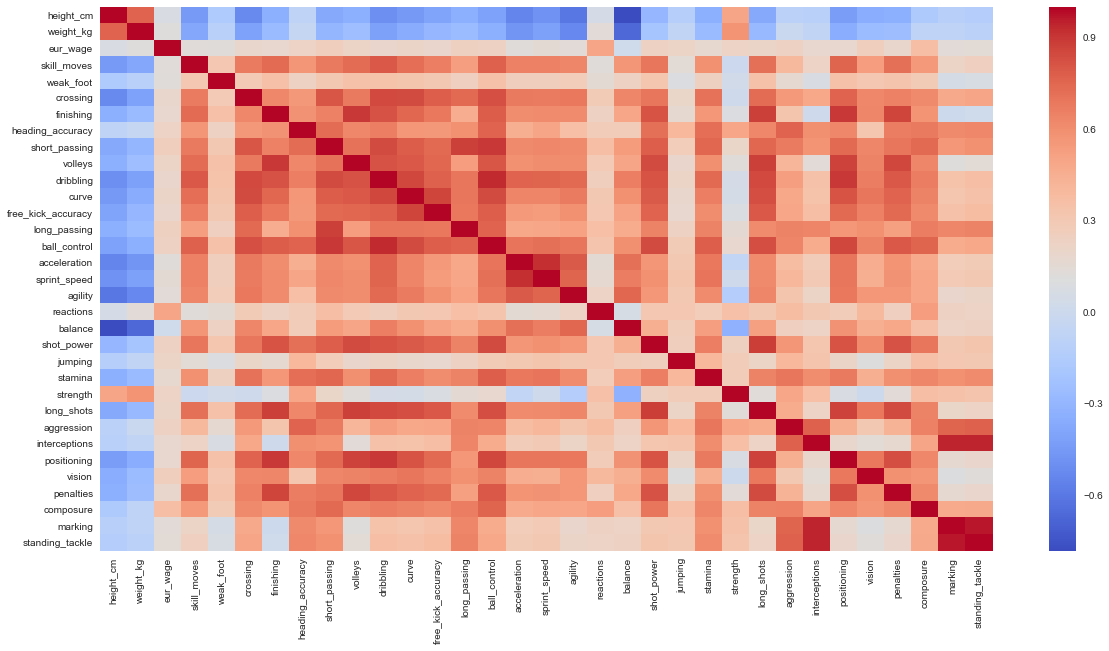

In [3]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(df.select_dtypes(include=['float64', 'int64']).corr(), ax=ax, cmap ='coolwarm')

# 2) Como o FIFA usa as características dos jogadores?

O FIFA não usa as caracteristicas de cada jogador diretamente, mas sim uma [média para compor atributos agregados](https://www.futnation.com/2017/3/28/15061828/fifa-fut-17-which-stats-are-best-important-ultimate-team):

<img src="https://cdn.vox-cdn.com/uploads/chorus_asset/file/8223237/Screen_Shot_2017_03_25_at_19.45.08.png" alt="drawing" width="800px" align='left'/>
<br clear="all" />


Aqui existem 28 atributos. Verificando se todos esses atributos estão no dataframe:


## 2.1) Nem todos atributos estão no csv



In [4]:
# atributos da imagem
att_img = ['acceleration', 'sprint_speed', 
           'positioning', 'finishing', 'shot_power', 'long_shots', 'volleys', 'penalties', 
           'vision', 'crossing', 'free_kick_accuracy', 'short_passing', 'long_passing', 'curve',
           'agility', 'balance', 'reactions', 'ball_control', 'dribbling',
           'interceptions', 'heading_accuracy', 'marking', 'standing_tackle', 'sliding_tackle',
           'jumping', 'stamina', 'strength', 'aggression']

# atributos do df
att_clm = df.select_dtypes(include=['float64', 'int64']).columns



In [5]:
for item in att_clm:
    if not item in att_img:
        print(item, item in att_img)
        
print('\n------------\n')

for item in att_img:
    if not item in att_clm:
        print(item, item in att_clm)

height_cm False
weight_kg False
eur_wage False
skill_moves False
weak_foot False
composure False

------------

sliding_tackle False


___
Esses atributos do csv não compõe os atributos agregados:

- height_cm  
- weight_kg  
- eur_wage   
- skill_moves
- weak_foot  
- composure  

Esse atributo não está no csv, então, a média terá que ser feita por 4 em Defending

- sliding_tackle

In [6]:
df['pace'] = df[['acceleration', 'sprint_speed']].mean(axis=1)
df['shooting'] = df[['positioning', 'finishing', 'shot_power', 'long_shots', 'volleys', 'penalties', ]].mean(axis=1)
df['passing'] = df[['vision', 'crossing', 'free_kick_accuracy', 'short_passing', 'long_passing', 'curve']].mean(axis=1)
df['dribling'] = df[['agility', 'balance', 'reactions', 'ball_control', 'dribbling']].mean(axis=1)
df['defending'] = df[['interceptions', 'heading_accuracy', 'marking', 'standing_tackle']].mean(axis=1)
df['physical'] = df[['jumping', 'stamina', 'strength', 'aggression']].mean(axis=1)

In [7]:
df[['pace','shooting','passing','dribling','defending','physical', 'preferred_pos']].head()

,pace,shooting,passing,dribling,defending,physical,preferred_pos
0,34.5,11.000000,14.500000,31.6,10.75,43.00,prefers_gk
1,67.0,48.500000,57.833333,69.6,53.25,63.50,prefers_cm
2,47.5,21.166667,27.500000,43.0,25.00,49.75,prefers_gk
3,69.5,69.000000,46.500000,57.6,35.75,63.50,prefers_st
4,33.0,32.166667,45.000000,36.6,71.00,68.50,prefers_cb


## 2.2) Média dos novos atributos para cada posição:

In [8]:
df[['pace','shooting','passing','dribling','defending','physical', 'preferred_foot','preferred_pos']].groupby('preferred_pos').mean()

,pace,shooting,passing,dribling,defending,physical
preferred_pos,,,,,,
prefers_cam,67.652866,55.367304,59.674098,66.467516,39.503185,54.363057
prefers_cb,56.876902,36.454640,42.056998,51.880931,66.697404,69.463966
prefers_cdm,61.795775,48.928795,54.958529,62.370892,61.545775,67.941315
prefers_cf,69.916667,56.333333,47.263889,64.116667,25.875000,51.166667
prefers_cm,64.775126,51.399079,56.922111,63.514070,51.138819,61.404523
prefers_gk,39.048187,15.483938,22.032988,35.301140,14.751295,44.067876
prefers_lb,71.881579,45.725146,54.921053,64.621053,61.519737,67.496345
prefers_lm,75.838710,55.606183,56.594086,67.070968,36.243952,55.939516
prefers_lw,76.243243,58.427928,55.337838,68.027027,31.560811,52.398649


## 2.3) Muitas posições! Reduzindo para 4 posições apenas:

Nas jogos mais antigos não existiam tantas posições. O [International Superstar Soccer Pro 98](https://www.youtube.com/watch?v=K7So22X1oTw) tinha apenas 4: **gk, df, mf e fw**.


In [9]:
# abstraindo a posicao preferida para gk, back, mid e forw. 

def absPosition(position):
    if position == 'prefers_gk':
        return 'gk'
    elif position == 'prefers_cb' or position == 'prefers_lb' or position == 'prefers_rb' or position == 'prefers_rwb' or position == 'prefers_lwb':
        return 'df'
    elif position == 'prefers_cam' or position == 'prefers_cdm' or position == 'prefers_rm' or position == 'prefers_cm' or position == 'prefers_lm':
        return 'mf'
    elif position == 'prefers_st' or position == 'prefers_cf' or position == 'prefers_lw' or position == 'prefers_rw':
        return 'fw'

df['pst'] = df['preferred_pos'].map(absPosition)

In [10]:
df_res = df[['pace','shooting','passing','dribling','defending','physical', 'pst']].groupby('pst').mean().reset_index()
df_res

,pst,pace,shooting,passing,dribling,defending,physical
0,df,62.761638,39.694803,46.377641,56.558385,64.729950,68.667975
1,fw,68.313288,62.561267,48.745070,62.933463,33.850630,62.782008
2,gk,39.048187,15.483938,22.032988,35.301140,14.751295,44.067876
3,mf,67.474286,52.621905,56.824921,64.615810,47.686905,60.334524


Por aqui já dá pra notar alguns padrões:

- Zagueiros tem um shooting PÉSSIMO, mas defendem bem e são fortes.
- Atacantes são HORRÍVEIS na marcação, mas driblam e chutam melhor que as outras posições
- Goleiros não fazem muitas coisas bem feitas haha. A média dos seus atributos talvez seja a mais baixa entre as posições
- Meia é a posição mais regular. Fazem bem as funções da outras posições



### 2.3.1) E como ficaria essa tabela com a visualização de um spider chart?

Lembro desse tipo de gráfico nas versões [mais antigas do PES](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSr136rnVQXuaqzWP_f0c6_HPsjGFpeyhaFa7Tjxt0EmB7L1AnshA).


In [11]:
# Retirado e adaptado de: https://python-graph-gallery.com/radar-chart/

def make_spider( row, title, color):

    # number of variable
    categories=[item.capitalize() for item in list(df_res)[1:]] # deixando a primeira letra maiúscula
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    # Ajustando o grid para 4 plot em uma linha
    ax = plt.subplot(1,4,row+1, polar=True)
    
    # https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib
    plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure
                        right = 1.5,    # the right side of the subplots of the figure
                        bottom = 0.1,   # the bottom of the subplots of the figure
                        top = 0.9,      # the top of the subplots of the figure
                        wspace = 0.2,   # the amount of width reserved for blank space between subplots
                        hspace = 0.2    # the amount of height reserved for white space between subplots
                       )
    

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=9)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(color="grey", size=9)
    plt.ylim(0,100)

    # Ind1
    values=df_res.loc[row].drop('pst').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=11, color=color, y=1.1)

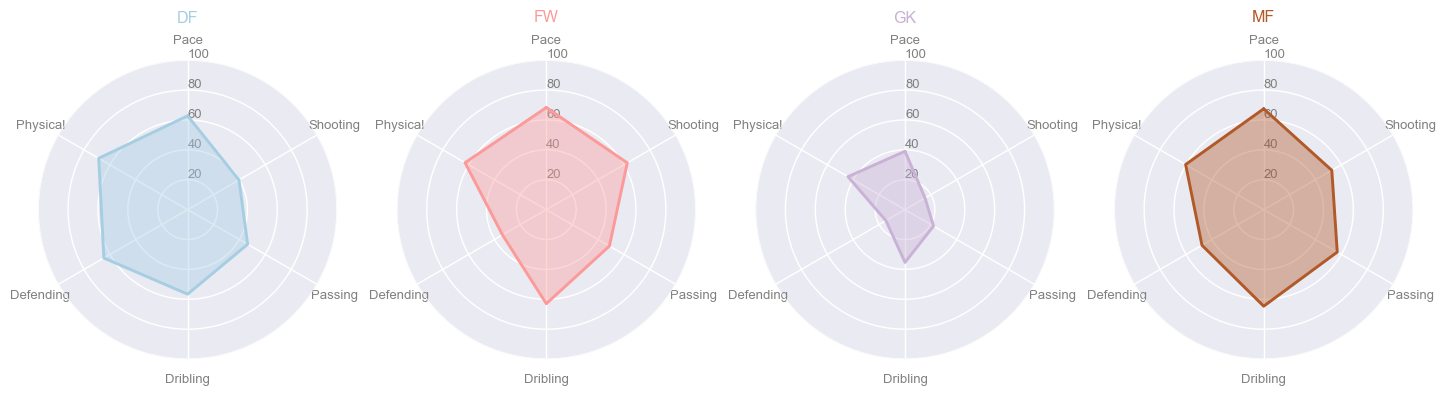

In [12]:
# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=105
fig = plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Paired", len(df_res.index))

# Loop to plot

for row in range(0, len(df_res.index)):
    make_spider(row=row, title=df_res.iloc[row,:1][0].upper(), color=my_palette(row))

# 3) Prevendo as posições do ISSP 98

Vamos tentar prever as 4 posições do Soccer Pro 98 **(gk, df, mf, fw)**. Bons padrões puderam ser observados antes.

O algoritmo utilizado será o **SVC (SVM Classificator)**. Esse algoritmo necessita de normalização dos dados antes que ele seja aplicado (https://neerajkumar.org/writings/svm/):

Mas qual normalização devo usar?

Existem 2 referências básicas de normalização de dados: 'Standardization' ou normalization(min max). Esse artigo http://sebastianraschka.com/Articles/2014_about_feature_scaling.html diz que *por via das dúvidas, usar Standardization.*

Aqui também tem um comentário útil: https://stackoverflow.com/questions/29819428/normalization-or-standardization-data-input-for-svm-scikitlearn


Para não ficar no 'e se', vamos fazer um modelo que use as 2 normalizações e ver o resultado:

In [13]:
X = df[['pace','shooting','passing','dribling','defending','physical']]
y = df['pst']

In [14]:
# Essa função também será usada no item 5 desse notebook.

def svc_model(X, y, split=0.25, mostraTodasPred=False, default_kernel='rbf', default_C=1):
    
    if 'preferred_foot' in X.columns: # convertendo em numero
        X.preferred_foot = X.preferred_foot.str.replace('Right', '0').replace('Left', '1').astype('int64')
    
    if 'pst' in X.columns: # convertendo em numero
        X.pst = X.pst.str.replace('gk', '0').replace('df', '1').replace('mf', '2').replace('fw', '3').astype('int64')
    
    # splitting train test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=0)
    
    # Dados stadardizados
    ss_std = StandardScaler()
    X_train_std = ss_std.fit_transform(X_train)
    X_test_std = ss_std.transform(X_test)
    clf_std = SVC(random_state=0, kernel=default_kernel, C=default_C)
    clf_std.fit(X_train_std, y_train)
    pred_std = clf_std.predict(X_test_std)
    count_std  = collections.Counter(pred_std)
    
    # y_test
    count_test = collections.Counter(y_test)
    
    # Mostrando o resultado final
    df_result = pd.DataFrame([dict(count_test), dict(count_std)]).T
    df_result.columns = ['y test','Pred. Orig.']
    
    if mostraTodasPred: # se quiser mostrar as predições com dados originais e mimax
        # predição com dados originais
        clf_orig = SVC(random_state=0, kernel=default_kernel, C=default_C)
        clf_orig.fit(X_train, y_train)
        count_orig = collections.Counter(clf_orig.predict(X_test))
        
        #Dados min max
        mimax = MinMaxScaler()
        X_train_mimax = mimax.fit_transform(X_train)
        X_test_mimax = mimax.transform(X_test)
        clf_mimax = SVC(random_state=0, kernel=default_kernel, C=default_C)
        clf_mimax.fit(X_train_mimax, y_train)
        count_mimax= collections.Counter(clf_mimax.predict(X_test_mimax))

        # Mostrando o resultado final
        df_result = pd.DataFrame([dict(count_test), dict(count_orig),dict(count_mimax), dict(count_std)]).T
        df_result.columns = ['y test', 'Pred. Orig.', 'Pred. MinMax', 'Pred. Std']
        
        print('Accuracy original: {0}'.format(clf_orig.score(X_test, y_test)))
        print('Accuracy min max : {0}'.format(clf_mimax.score(X_test_mimax, y_test)))
        
    print('Accuracy standard: {0}'.format(clf_std.score(X_test_std, y_test)))
    print('')
    print(df_result)

    if mostraTodasPred:
        return [X_train, X_train_std, X_train_mimax, y_train, y_test, pred_std]
    else:
        return [X_train, X_train_std, y_train, y_test, pred_std]

In [15]:
result = svc_model(X,y, mostraTodasPred=True)

Accuracy original: 0.4379139072847682
Accuracy min max : 0.9089403973509934
Accuracy standard: 0.9279801324503312

    y test  Pred. Orig.  Pred. MinMax  Pred. Std
df     418         1095           471        451
fw     251            8           250        250
gk     254           96           254        254
mf     285            9           233        253


Colocar os dados em uma escala melhorou o resultado da previsão! Dependendo da aleatoriedade da amostra o min max ou o standard podem ficar um pouco melhor ou um pouco pior que o outro, então praticamente não possuem diferença para esse modelo.


## 3.1) Plotando dados originais e tranformações

Como ficam os dados distribuídos em um gráfico com todas essas tranformações?

> **Standard scaler**: distribution is now centred around 0, with a standard deviation of 1

> **Min max scaler**: the range is now between 0 and 1 (or -1 to 1 if there are negative values)


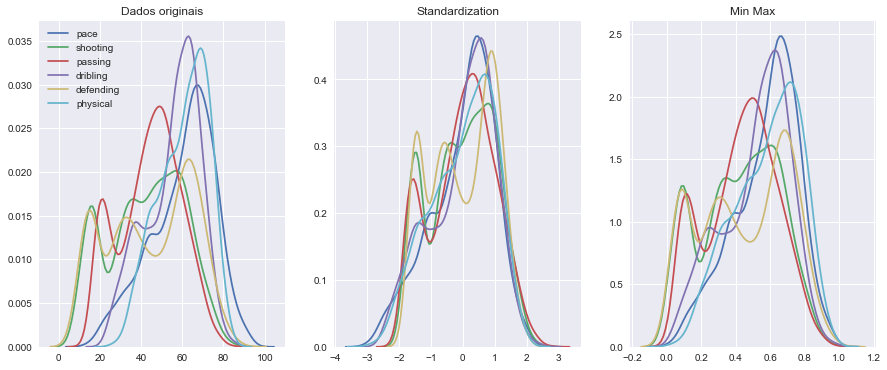

In [16]:
# Função usada para criar os gráficos após a transformação dos dados

def distTypeCharts(X_train, X_train_stand, X_train_mimax): #(DataFrame, Serie, Serie)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 6))

    for col in X_train.columns:
        sns.kdeplot(X_train[col], ax=ax1)

    # df apenas para montar o gráfico
    X_train_stand_df = pd.DataFrame(X_train_stand, columns=['pace','shooting','passing','dribling','defending','physical'])
    for col in X_train_stand_df.columns:
        sns.kdeplot(X_train_stand_df[col], ax=ax2)

    # df apenas para montar o gráfico
    X_train_mimax_df = pd.DataFrame(X_train_mimax, columns=['pace','shooting','passing','dribling','defending','physical'])
    for col in X_train_mimax_df.columns:
        sns.kdeplot(X_train_mimax_df[col], ax=ax3)

    # melhorando a aparencia    
    ax1.set_title('Dados originais')
    ax2.set_title('Standardization')
    ax3.set_title('Min Max')

    ax2.legend_.remove()
    ax3.legend_.remove()
    
# função de previsão retorna tupla de 4 posições. A utlima posição é apenas para
# criar esses graficos.
distTypeCharts(result[0], result[1], result[2])

## 3.2) Conclusão

Caso quiséssemos as posições para o ISSP 98, teríamos um modelo com uma accuracy muito boa. Entretanto, precisamos especificar um pouco mais nosso modelo. 

Para cada posição existem as subposições que diferem quanto à perna predominante e se o jogador tem caracteristicas predominantes de atacante ou zagueiro. Vamos tentar descobrir alguns padrões:

# 4) Explorando subposições


## 4.1) Investigando os zagueiros

Os backs dividem-se em 5 posições específicas:

- prefers_lwb
- prefers_lb
- prefers_cb
- prefers_rb
- prefers_rwb


Além de usar nossas varáveis do ISSP98 e as posições, temos que observar que existem os lados que os jogadores gostam de jogar. Chuto, quase afirmando, que isso tem a ver com o pé predominante. Vamos aos padrões:

In [17]:
df_z = df[df.pst == 'df'][['pace','shooting','passing','dribling','defending','physical', 'preferred_foot','preferred_pos']]
df_z.head(2)

,pace,shooting,passing,dribling,defending,physical,preferred_foot,preferred_pos
4,33.0,32.166667,45.000000,36.6,71.0,68.50,Right,prefers_cb
7,77.0,30.666667,39.666667,54.2,50.0,57.75,Right,prefers_rb


In [18]:
df_z.groupby('preferred_pos').mean()

,pace,shooting,passing,dribling,defending,physical
preferred_pos,,,,,,
prefers_cb,56.876902,36.454640,42.056998,51.880931,66.697404,69.463966
prefers_lb,71.881579,45.725146,54.921053,64.621053,61.519737,67.496345
prefers_lwb,71.875000,43.375000,48.875000,62.800000,54.812500,61.312500
prefers_rb,73.429245,44.473270,52.301363,64.185535,61.482704,67.252358
prefers_rwb,75.500000,51.000000,51.666667,65.000000,51.000000,64.250000


In [19]:
df_z.groupby(['preferred_pos','preferred_foot']).size()

preferred_pos  preferred_foot
prefers_cb     Left              206
               Right             911
prefers_lb     Left              324
               Right              18
prefers_lwb    Left                3
               Right               1
prefers_rb     Left                3
               Right             315
prefers_rwb    Right               2
dtype: int64

Sem consultar o que cada posição significa, podemos inferir algumas informações:

- cb são nossos xerifões. O Lúcio cai bem nessa definição :D. São lentos, chute e passe ruins (drible nem se fala) mas são os melhores para defender possuindo também a maior média física.
- lb/rb são em geral mais habilidosos. Além de terem bom passe, também defendem bem.
- lwb/rwb diferenciam-se pois não são tão bons em marcar e possuem porte físico menor. Chuto que são laterais ofensivos.

Vamos googlear e ver se é [isso mesmo](http://fifafootballvideogames.wikia.com/wiki/Soccer_positions):

> - Centre-backs are often tall, strong and have a good jumping, heading and tackling ability.
> - The Right Back and The Left Back are the side defenders, not like the wingbacks. They are the second common defender (first being Centre-Backs).
> - The Wingbacks are defenders with heavier emphasis on attack.

Muito bom! É isso aí!


In [20]:
df.preferred_foot.value_counts(normalize=True)

Right    0.791882
Left     0.208118
Name: preferred_foot, dtype: float64

Já ia me esquecendo, pés predominantes! De certa forma existem mais destros do que canhotos no csv de treinamento: 80% são destros. Olhando para cada posição vemos um padrão: *1) quem joga na esquerda, é canhoto e vice-versa e 2) quem joga no meio geralmente é destro*. 

Como esse padrão é bem forte, podemos usá-lo em nosso modelo. Faremos essa verificação nas outras posições também. 

## 4.2) Invetigando meio-campistas

In [21]:
mf_m = df[df.pst == 'mf'][['pace','shooting','passing','dribling','defending','physical', 'preferred_foot','preferred_pos']]
mf_m.head(2)

,pace,shooting,passing,dribling,defending,physical,preferred_foot,preferred_pos
1,67.0,48.5,57.833333,69.6,53.25,63.5,Right,prefers_cm
15,55.5,55.5,55.666667,57.6,68.50,71.0,Right,prefers_cdm


In [22]:
mf_m.groupby('preferred_pos').mean()

,pace,shooting,passing,dribling,defending,physical
preferred_pos,,,,,,
prefers_cam,67.652866,55.367304,59.674098,66.467516,39.503185,54.363057
prefers_cdm,61.795775,48.928795,54.958529,62.370892,61.545775,67.941315
prefers_cm,64.775126,51.399079,56.922111,63.514070,51.138819,61.404523
prefers_lm,75.838710,55.606183,56.594086,67.070968,36.243952,55.939516
prefers_rm,75.186709,55.610759,56.446203,66.650633,37.420886,56.767405


Em um primeiro momento, os padrões não pareceram estar tão visíveis. Tive que recorrer à pesquisa antes de inferir qualquer coisa:

> - Central midfielders play several roles on the field of play, depending on their particular strengths and the tactics of the team.
> - The Left and Right Midfielders (or The side midfielder) is a midfielder who is stationed in a wide position effectively hugging the touchline.
> - An Attacking midfielder is a central midfielder who is stationed in an advanced midfield position, usually behind the strikers.
> - A Defensive midfielder is a central midfielder who is stationed in front of the defenders to provide a more secure defence, thus "holding back" the freedom of the opponents to attack.

A evolução do futebol tanto real quanto virtual é algo muito interessante. Agora existem posições bem definidas para os volantes que saem jogando e os que ficam mais na marcação. Todos eram meio campistas centrais antigamente. Ponto para a evolução!

- cm: meio campistas centrais. Muito regulares. Atacam mais do que defendem.
- lm/rm: possuem bom preparo físico. Ficam mais abertos nas laterais do campo. Não marcam NADA!
- cam: ataque consistente com bom passe (garçom dos atacantes) e marca pouco. Já esperado pelo seu papel no campo.
- cdm: um exemplo bom aqui seria o nosso Casemito. A ênfase está na defesa e no porte físico e como era de se esperar, chute bem fraco.

In [23]:
mf_m.groupby(['preferred_pos','preferred_foot']).size()

preferred_pos  preferred_foot
prefers_cam    Left               33
               Right             124
prefers_cdm    Left               24
               Right             189
prefers_cm     Left               56
               Right             342
prefers_lm     Left               68
               Right              56
prefers_rm     Left               25
               Right             133
dtype: int64

O destaque aqui são os meia-esquerdas. A proporção de destros e canhotos está bem próxima, isso talvez seja explicável pelo mesmo fato do [Robben jogar na direita e ser canhoto](https://www.youtube.com/watch?v=T98BWzUlkY4): cortar para dentro e bater pro gol.


Como existem mais destros em geral, então, é esperado que a proporção fique parecida.

## 4.3) Investigando os atacantes

In [24]:
fw_f = df[df.pst == 'fw'][['pace','shooting','passing','dribling','defending','physical', 'preferred_foot','preferred_pos']]
fw_f.head(2)

,pace,shooting,passing,dribling,defending,physical,preferred_foot,preferred_pos
3,69.5,69.000000,46.5,57.6,35.75,63.5,Left,prefers_st
5,72.5,67.833333,43.0,67.2,29.50,64.0,Right,prefers_st


In [25]:
fw_f.groupby('preferred_pos').mean()

,pace,shooting,passing,dribling,defending,physical
preferred_pos,,,,,,
prefers_cf,69.916667,56.333333,47.263889,64.116667,25.875000,51.166667
prefers_lw,76.243243,58.427928,55.337838,68.027027,31.560811,52.398649
prefers_rw,73.575472,59.537736,55.150943,66.056604,32.367925,52.646226
prefers_st,67.676534,62.978830,48.136168,62.537137,34.129440,63.923843


Roberto Carlos foi um dos maiores goleadores que os video games já viram. TODOS já apelaram com ele!

<img src="http://pbs.twimg.com/media/CX1EgqgWcAAx1YO.jpg" alt="drawing" width="350px" align='left'/>
<br clear="all" />


- st são os goleadores, simples assim. Em geral não são rápidos, mas quando a bola cai no pé são decisivos. Possuem porte físico avantajado.
- cf são os segundos atacantes. Possuem maior mobilidade e são mais habilidosos. Existem as variações para lado direito e esquerdo dessa posição também.
- lw/rw enquadram-se como alas. Esses jogadores incomodam muito a defesa adversária jogando na extremidade dos lados do campo. Possuem muito bom condicionamento físico e são muito habilidosos.



In [26]:
fw_f.groupby(['preferred_pos','preferred_foot']).size()

preferred_pos  preferred_foot
prefers_cf     Left                4
               Right               8
prefers_lw     Left               12
               Right              25
prefers_rw     Left               21
               Right              32
prefers_st     Left              124
               Right             805
dtype: int64

Da mesma forma que acontece com meias que jogam abertos no campo, aqui também há a ocorrência de destros e canhotos em lados opostos do campo.

## 5) Como ficaria a predição usando a feature de pé predominante?

In [27]:
dft = df[['pst', 'pace','shooting','passing','dribling','defending','physical', 'preferred_foot','preferred_pos']]

In [28]:
print(dft[dft.pst == 'df'].iloc[:,1:-1].head(1))
print('-----------------------')
print(dft[dft.pst == 'df'].preferred_pos.head(1))

   pace   shooting  passing  dribling  defending  physical preferred_foot
4  33.0  32.166667     45.0      36.6       71.0      68.5          Right
-----------------------
4    prefers_cb
Name: preferred_pos, dtype: object


## 5.1) Zagueiros

In [29]:
X = dft[dft.pst == 'df'].iloc[:,1:-1] # 1) filtrando df 2) tirando pst e preferred_pos
y = dft[dft.pst == 'df'].preferred_pos

result = svc_model(X, y)

Accuracy standard: 0.9260089686098655

             y test  Pred. Orig.
prefers_cb    263.0        266.0
prefers_lb     96.0         91.0
prefers_rb     86.0         89.0
prefers_rwb     1.0          NaN


## 5.2) Meias

In [30]:
X = dft[dft.pst == 'mf'].iloc[:,1:-1] # 1) filtrando df 2) tirando pst e preferred_pos
y = dft[dft.pst == 'mf'].preferred_pos

result = svc_model(X, y)

Accuracy standard: 0.6463878326996197

             y test  Pred. Orig.
prefers_cam      44           29
prefers_cdm      52           50
prefers_cm      102          129
prefers_lm       30           21
prefers_rm       35           34


O modelo não conseguiu prever com exatidão cm e cdm. Os erros nessas 2 posições foram bem acima das outras.

## 5.3) Atacantes

In [31]:
X = dft[dft.pst == 'fw'].iloc[:,1:-1] # 1) filtrando df 2) tirando pst e preferred_pos
y = dft[dft.pst == 'fw'].preferred_pos

result = svc_model(X, y)

Accuracy standard: 0.9147286821705426

            y test  Pred. Orig.
prefers_cf     4.0          NaN
prefers_lw     7.0          6.0
prefers_rw    15.0          7.0
prefers_st   232.0        245.0


# 6) Prevendo as posições com features de média e ISSP98 juntas:

Os resultados foram muito bons com as features das médias e do ISSP98 separadamente. Mas será que se eu colocar essas features juntas, o modelo conseguirá prever corretamente? Ainda tem a baixa accuracy dos meias. Let´s try!

In [32]:
dft = df[['pst', 'pace','shooting','passing','dribling','defending','physical', 'preferred_foot','preferred_pos']]
X = dft.iloc[:,:-1]
y = dft.preferred_pos

print(X.head(1))
print('-----------------------')
print(y.head(1))

  pst  pace  shooting  passing  dribling  defending  physical preferred_foot
0  gk  34.5      11.0     14.5      31.6      10.75      43.0          Right
-----------------------
0    prefers_gk
Name: preferred_pos, dtype: object


In [33]:
result = svc_model(X, y, split=0.3)

Accuracy standard: 0.8674948240165632

             y test  Pred. Orig.
prefers_cam    38.0         48.0
prefers_cb    330.0        322.0
prefers_cdm    63.0         62.0
prefers_cf      3.0          NaN
prefers_cm    134.0        156.0
prefers_gk    295.0        295.0
prefers_lb     93.0         95.0
prefers_lm     32.0         33.0
prefers_lw     10.0          NaN
prefers_rb     83.0         89.0
prefers_rm     68.0         36.0
prefers_rw     21.0          6.0
prefers_st    279.0        307.0


O accuraccy do nosso modelo está com um nível bastante aceitável. Mas será que conseguimos melhorar se aplicarmos outro algoritmo?

## 7) Comparando com o algoritmo Random Forest

O modelo ficou com uma accuracy boa com o SVC. Vamos compará-lo com o Random Forest e verificar se os resultados são compatíveis:

In [34]:
def rf_model(X, y, split=.25):
    if 'preferred_foot' in X.columns:
        X.preferred_foot = X.preferred_foot.str.replace('Right', '0').replace('Left', '1').astype('int64')
    
    if 'pst' in X.columns:
        X.pst = X.pst.str.replace('gk', '0').replace('df', '1').replace('mf', '2').replace('fw', '3').astype('int64')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=1891)
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    
    dfr = pd.DataFrame([pd.Series(result).value_counts(), y_test.value_counts()]).T
    dfr.columns = ['pred', 'real']
    
    print('Accuracy score: {0}\n'.format(accuracy_score(y_test, result, normalize=True)))
    print(dfr)
    
    return clf, X_train, X_test, y_train, y_test


## 7.1.1) Modelo que usa pé predominante mas não usa posições do ISSP98:

In [35]:
X = df[['pace','shooting','passing','dribling','defending','physical','preferred_foot', 'pst', 'preferred_pos']].iloc[:,:-2]
y = df[['pace','shooting','passing','dribling','defending','physical','preferred_foot', 'pst', 'preferred_pos']].iloc[:,-1]


In [36]:
result = rf_model(X,y, split=0.3)

Accuracy score: 0.8053830227743272

              pred   real
prefers_cb   371.0  336.0
prefers_gk   296.0  296.0
prefers_st   289.0  272.0
prefers_cm   120.0  131.0
prefers_lb   108.0  106.0
prefers_rb    93.0   89.0
prefers_cdm   55.0   71.0
prefers_cam   48.0   42.0
prefers_rm    34.0   42.0
prefers_lm    30.0   35.0
prefers_lw     3.0    8.0
prefers_rw     2.0   15.0
prefers_cf     NaN    4.0
prefers_lwb    NaN    1.0
prefers_rwb    NaN    1.0


## 7.1.2) Modelo que usa posições do ISSSP98 e pé predominante:

In [37]:
X = df[['pace','shooting','passing','dribling','defending','physical','preferred_foot', 'pst', 'preferred_pos']].iloc[:,:-1]
y = df[['pace','shooting','passing','dribling','defending','physical','preferred_foot', 'pst', 'preferred_pos']].iloc[:,-1]

In [38]:
result2 = rf_model(X, y, split=0.3)

Accuracy score: 0.8585231193926847

              pred   real
prefers_cb   346.0  336.0
prefers_gk   296.0  296.0
prefers_st   282.0  272.0
prefers_cm   127.0  131.0
prefers_lb    98.0  106.0
prefers_rb    87.0   89.0
prefers_cdm   81.0   71.0
prefers_cam   56.0   42.0
prefers_rm    35.0   42.0
prefers_lm    23.0   35.0
prefers_lw     9.0    8.0
prefers_rw     8.0   15.0
prefers_lwb    1.0    1.0
prefers_cf     NaN    4.0
prefers_rwb    NaN    1.0


Da mesma forma que aconteceu com o SVC, com o Random Forest a feature do ISSP98 melhorou bastante o modelo. Tanto SVC quanto o Random Forest pareceram ter desempenho semelhante. Dessa forma, vamos ficar com o SVC para predição e usar o Random Forest como comparação apenas.

## 7.2) Tentando encontrar melhores parâmetros

Escolhendo melhor os parâmetros para usar com SVC:

In [39]:
parameters = {'kernel':('linear', 'rbf'),
              'C':[1, 10, 100]
             }

clf = GridSearchCV(estimator=SVC(random_state=5891), param_grid=parameters, n_jobs=-1)
clf.fit(result2[1],result2[3])

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=5891, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [40]:
print(clf.best_estimator_)
print('\n')
print(clf.best_score_)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=5891, shrinking=True,
  tol=0.001, verbose=False)


0.8656804733727811


Agora podemos alterar os hyperparametros com ```Kernel=linear``` e ```C=1```.

## 8) Modelo final

In [41]:
X = df[['pace','shooting','passing','dribling','defending','physical','preferred_foot', 'pst', 'preferred_pos']].iloc[:,:-1]
y = df[['pace','shooting','passing','dribling','defending','physical','preferred_foot', 'pst', 'preferred_pos']].iloc[:,-1]

result = svc_model(X, y, default_kernel='linear', default_C=1)

Accuracy standard: 0.8667218543046358

             y test  Pred. Orig.
prefers_cam    28.0         43.0
prefers_cb    285.0        266.0
prefers_cdm    53.0         61.0
prefers_cf      2.0          NaN
prefers_cm    118.0        123.0
prefers_gk    254.0        254.0
prefers_lb     67.0         74.0
prefers_lm     28.0         26.0
prefers_lw      7.0          4.0
prefers_rb     66.0         78.0
prefers_rm     58.0         32.0
prefers_rw     19.0         14.0
prefers_st    223.0        233.0


## 8.1) Confusion matrix

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

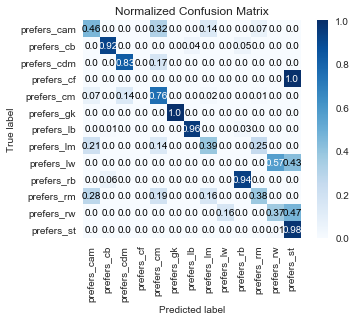

In [42]:
skplt.metrics.plot_confusion_matrix(result[3], result[4], normalize=True)
plt.xticks(rotation=90)

Pela confusion matrix fica bem perceptível o ponto fraco do modelo. A única posição com accuracy boa no meio de campo, é o cdm. Comparado às outras subposições, cm também não foi tão mal. Se quiséssemos melhorar o modelo, um caminho a ser seguido certamente seria melhorar o modelo quanto às subposições dos meias.

Outro destaque negativo é o cf. Entretanto, essa discrepância se dê mais em função do desbalanceamento do dataset do que outra coisa. Talvez se o dataset estivesse balanceado, essa posição poderia ser prevista melhor.

Os lw foram classificados com a perna errada. O modelo aqui poderia ir melhor também se tivesse balanceamento dos dados.

Não são apenas pontos negativos que marcam o modelo. Os goleiros tiveram 100% de acerto na previsão e de modo geral as posições ficaram bem rankeadas. Basta olhar a diagonal do gráfico. Quanto mais colorido, melhor.